In [1]:
# Set Colab to GPU: Runtime > Change runtime type > GPU

import tensorflow as tf, os, random, shutil, zipfile, pathlib
print("TF:", tf.__version__)
print("GPU:", tf.config.list_physical_devices('GPU'))


TF: 2.19.0
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# Upload your kaggle.json (Kaggle > Account > Create New API Token)
from google.colab import files
uploaded = files.upload()

os.makedirs("/root/.kaggle", exist_ok=True)
shutil.move("kaggle.json", "/root/.kaggle/kaggle.json")
os.chmod("/root/.kaggle/kaggle.json", 0o600)

!kaggle datasets download -d shaunthesheep/microsoft-catsvsdogs-dataset -p /content/data

zip_path = "/content/data/microsoft-catsvsdogs-dataset.zip"
with zipfile.ZipFile(zip_path, "r") as z:
    z.extractall("/content/data")

# Detect PetImages folder across common archive layouts
candidates = [
    "/content/data/PetImages",
    "/content/data/microsoft_cats_vs_dogs/PetImages",
    "/content/data/kagglecatsanddogs_3367a/PetImages",
]
pet_dir = None
for c in candidates:
    if os.path.isdir(c) and os.path.isdir(os.path.join(c, "Cat")) and os.path.isdir(os.path.join(c, "Dog")):
        pet_dir = c
        break

assert pet_dir, f"Could not find PetImages in {candidates}"
print("Dataset path:", pet_dir)


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/shaunthesheep/microsoft-catsvsdogs-dataset
License(s): other
 88% 693M/788M [00:06<00:01, 52.0MB/s]
100% 788M/788M [00:07<00:00, 118MB/s] 
Dataset path: /content/data/PetImages


In [3]:
import os, pathlib, shutil, random
from PIL import Image

def is_ok_image(path: str) -> bool:
    """Quick verification that file opens and is not tiny."""
    try:
        with Image.open(path) as im:
            im.verify()
        with Image.open(path) as im:
            _ = im.getbands()
        return os.path.getsize(path) > 1024
    except Exception:
        return False

def list_images(dirpath: str):
    exts = ("*.jpg", "*.jpeg", "*.png", "*.JPG", "*.JPEG", "*.PNG")
    files = []
    p = pathlib.Path(dirpath)
    for pat in exts:
        files.extend([str(x) for x in p.glob(pat)])
    return sorted(files)

cats_raw = list_images(os.path.join(pet_dir, "Cat"))
dogs_raw = list_images(os.path.join(pet_dir, "Dog"))

# Filter corrupted or tiny files
cats_all = [p for p in cats_raw if is_ok_image(p)]
dogs_all = [p for p in dogs_raw if is_ok_image(p)]

print(f"After cleaning -> Cats: {len(cats_all)}  Dogs: {len(dogs_all)}")

random.seed(7)
random.shuffle(cats_all)
random.shuffle(dogs_all)

def _safe_encode_to_rgb(src_path: str, dest_path: str) -> bool:
    """Open with PIL, convert to RGB, save JPEG. Returns True if saved OK."""
    try:
        with Image.open(src_path) as im:
            im = im.convert("RGB")
            im.save(dest_path, format="JPEG", quality=95, optimize=True)
        return True
    except Exception:
        return False

def _copy_as_rgb(src_list, start, end, dest_dir, prefix):
    os.makedirs(dest_dir, exist_ok=True)
    saved, skipped = 0, 0
    for i, p in enumerate(src_list[start:end], start=1):
        fn = f"{prefix}_{i:06d}.jpg"
        ok = _safe_encode_to_rgb(p, os.path.join(dest_dir, fn))
        if ok:
            saved += 1
        else:
            skipped += 1
    return saved, skipped

def build_balanced_split(root_out, train_per_class, val_per_class=250, test_per_class=250,
                         cats_src=cats_all, dogs_src=dogs_all):
    """Create train/val/test folders, re-encoding every image to 3-channel RGB JPEG and skipping bad ones."""
    need = train_per_class + val_per_class + test_per_class
    if len(cats_src) < need or len(dogs_src) < need:
        raise ValueError("Not enough clean source images per class. Reduce counts or expand pools.")

    # Clean destination tree
    if os.path.exists(root_out):
        shutil.rmtree(root_out)
    for split in ["train", "val", "test"]:
        for cls in ["Cat", "Dog"]:
            os.makedirs(os.path.join(root_out, split, cls), exist_ok=True)

    # Take a small buffer in case a few images fail re-encode
    buffer = int(need * 0.15) + 50
    cats_pool = cats_src[:need + buffer]
    dogs_pool = dogs_src[:need + buffer]

    # Index ranges
    c_train_s, c_train_e = 0, train_per_class
    c_val_s,   c_val_e   = c_train_e, c_train_e + val_per_class
    c_test_s,  c_test_e  = c_val_e,   c_val_e + test_per_class

    d_train_s, d_train_e = 0, train_per_class
    d_val_s,   d_val_e   = d_train_e, d_train_e + val_per_class
    d_test_s,  d_test_e  = d_val_e,   d_val_e + test_per_class

    # Encode Cats
    a,b = _copy_as_rgb(cats_pool, c_train_s, c_train_e, os.path.join(root_out, "train", "Cat"), "cat_tr")
    c,d = _copy_as_rgb(cats_pool, c_val_s,   c_val_e,   os.path.join(root_out, "val",   "Cat"), "cat_va")
    e,f = _copy_as_rgb(cats_pool, c_test_s,  c_test_e,  os.path.join(root_out, "test",  "Cat"), "cat_te")

    # Encode Dogs
    g,h = _copy_as_rgb(dogs_pool, d_train_s, d_train_e, os.path.join(root_out, "train", "Dog"), "dog_tr")
    i,j = _copy_as_rgb(dogs_pool, d_val_s,   d_val_e,   os.path.join(root_out, "val",   "Dog"), "dog_va")
    k,l = _copy_as_rgb(dogs_pool, d_test_s,  d_test_e,  os.path.join(root_out, "test",  "Dog"), "dog_te")

    # Validate counts
    def count_imgs(p): return len(list(pathlib.Path(p).glob("*.jpg")))
    ct = count_imgs(os.path.join(root_out, "train", "Cat"))
    dt = count_imgs(os.path.join(root_out, "train", "Dog"))
    cv = count_imgs(os.path.join(root_out, "val",   "Cat"))
    dv = count_imgs(os.path.join(root_out, "val",   "Dog"))
    cte= count_imgs(os.path.join(root_out, "test",  "Cat"))
    dte= count_imgs(os.path.join(root_out, "test",  "Dog"))

    print(f"[Cats saved/skipped] train {a}/{b}, val {c}/{d}, test {e}/{f}")
    print(f"[Dogs saved/skipped] train {g}/{h}, val {i}/{j}, test {k}/{l}")
    print(f"[Final counts] train: Cat={ct}, Dog={dt} | val: Cat={cv}, Dog={dv} | test: Cat={cte}, Dog={dte}")

    assert ct == train_per_class and dt == train_per_class, "Did not meet train counts. Increase buffer or reduce size."
    assert cv == val_per_class   and dv == val_per_class,   "Did not meet val counts. Increase buffer or reduce size."
    assert cte == test_per_class and dte == test_per_class, "Did not meet test counts. Increase buffer or reduce size."

    return root_out


After cleaning -> Cats: 12497  Dogs: 12498


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


In [4]:
import tensorflow as tf, os

IMG_SIZE = (224, 224)   # good for VGG16 and general transfer
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

# Mild aug is usually enough for transfer
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.1),
])

def make_datasets(root_out):
    train_ds = tf.keras.utils.image_dataset_from_directory(
        os.path.join(root_out, "train"),
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        label_mode="binary",
        color_mode="rgb",
        shuffle=True,
    )
    val_ds = tf.keras.utils.image_dataset_from_directory(
        os.path.join(root_out, "val"),
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        label_mode="binary",
        color_mode="rgb",
        shuffle=False,
    )
    test_ds = tf.keras.utils.image_dataset_from_directory(
        os.path.join(root_out, "test"),
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        label_mode="binary",
        color_mode="rgb",
        shuffle=False,
    )

    def prep(ds, training=False):
        ds = ds.cache()
        if training:
            ds = ds.shuffle(2048)
        return ds.prefetch(AUTOTUNE)

    return prep(train_ds, True), prep(val_ds), prep(test_ds)


In [5]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

def make_vgg_transfer_model(input_shape=IMG_SIZE+(3,), dropout=0.2, train_base=False, unfreeze_from=None):
    base = VGG16(include_top=False, weights="imagenet", input_shape=input_shape)

    # Freeze or selectively unfreeze
    if not train_base:
        base.trainable = False
    else:
        base.trainable = True
        if unfreeze_from is not None:
            set_trainable = False
            for layer in base.layers:
                if layer.name == unfreeze_from:
                    set_trainable = True
                layer.trainable = set_trainable

    inputs = layers.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = layers.Lambda(preprocess_input)(x)  # VGG16 preprocessing
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = models.Model(inputs, outputs)
    # LR: higher for transfer-only, lower for fine-tune
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4 if not train_base else 1e-5),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model


In [6]:
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import pandas as pd, os

def train_and_evaluate(model, train_ds, val_ds, test_ds, tag, epochs=15):
    os.makedirs("/content/checkpoints", exist_ok=True)
    ckpt = f"/content/checkpoints/{tag}_best.keras"
    callbacks = [
        EarlyStopping(patience=5, restore_best_weights=True, monitor="val_accuracy"),
        ReduceLROnPlateau(patience=2, factor=0.5, min_lr=1e-6, monitor="val_loss"),
        ModelCheckpoint(ckpt, save_best_only=True, monitor="val_accuracy"),
    ]
    history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=callbacks, verbose=1)
    test_loss, test_acc = model.evaluate(test_ds, verbose=0)

    plt.figure()
    plt.plot(history.history["accuracy"], label="train_acc")
    plt.plot(history.history["val_accuracy"], label="val_acc")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.title(f"Accuracy - {tag}")
    plt.show()

    plt.figure()
    plt.plot(history.history["loss"], label="train_loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.title(f"Loss - {tag}")
    plt.show()

    best_val = float(max(history.history["val_accuracy"]))
    return {"run": tag, "best_val_acc": best_val, "test_acc": float(test_acc)}


[Cats saved/skipped] train 500/0, val 250/0, test 250/0
[Dogs saved/skipped] train 500/0, val 250/0, test 250/0
[Final counts] train: Cat=500, Dog=500 | val: Cat=250, Dog=250 | test: Cat=250, Dog=250
Found 1000 files belonging to 2 classes.
Found 500 files belonging to 2 classes.
Found 500 files belonging to 2 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 297ms/step - accuracy: 0.5133 - loss: 3.1355 - val_accuracy: 0.5580 - val_loss: 2.1589 - learning_rate: 1.0000e-04
Epoch 2/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 191ms/step - accuracy: 0.5210 - loss: 2.2516 - val_accuracy: 0.6040 - val_loss: 1.5117 - learning_rate: 1.0000e-04
Epoch 3/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 186ms/step - accuracy: 0.6047 - loss: 1.6662 - val_accuracy: 0.6520 - val_loss: 1.2448 - learning_rate: 1.0000e-04
Epoch 4/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 184ms/step - accuracy: 0.6456 - loss: 1.4932 - val_accuracy: 0.7040 - val_loss: 1.0737 - learning_rate: 1.0000e-04
Epo

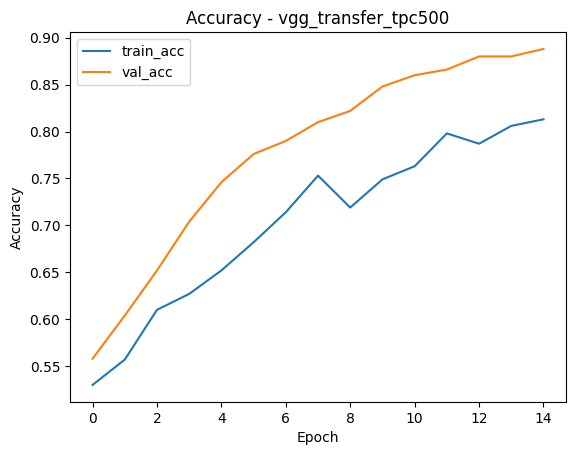

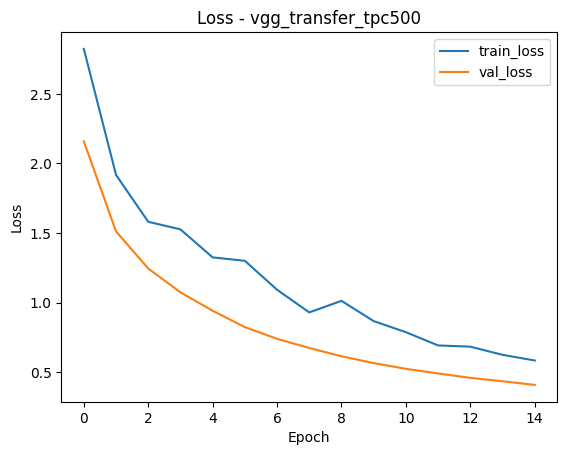

[Cats saved/skipped] train 2000/0, val 250/0, test 250/0
[Dogs saved/skipped] train 2000/0, val 250/0, test 250/0
[Final counts] train: Cat=2000, Dog=2000 | val: Cat=250, Dog=250 | test: Cat=250, Dog=250
Found 4000 files belonging to 2 classes.
Found 500 files belonging to 2 classes.
Found 500 files belonging to 2 classes.
Epoch 1/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 26s 146ms/step - accuracy: 0.3764 - loss: 3.7690 - val_accuracy: 0.4500 - val_loss: 2.5357 - learning_rate: 1.0000e-04
Epoch 2/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 148ms/step - accuracy: 0.5006 - loss: 2.2511 - val_accuracy: 0.6280 - val_loss: 1.3671 - learning_rate: 1.0000e-04
Epoch 3/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 145ms/step - accuracy: 0.6351 - loss: 1.3901 - val_accuracy: 0.7420 - val_loss: 0.8184 - learning_rate: 1.0000e-04
Epoch 4/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 143ms/step - accuracy: 0.7357 - loss: 0.9041 - val_accuracy: 0.8260 - val_loss: 0.5610 - learning_rate: 1.0000e-04
Epoch 5/15
125/125 ━━━━━━━━━━━━━━━━━━━━

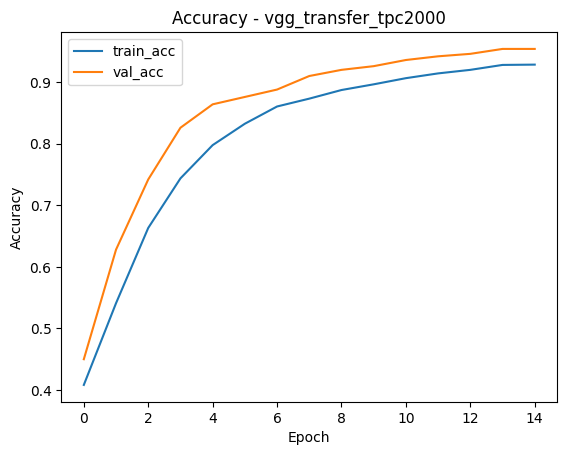

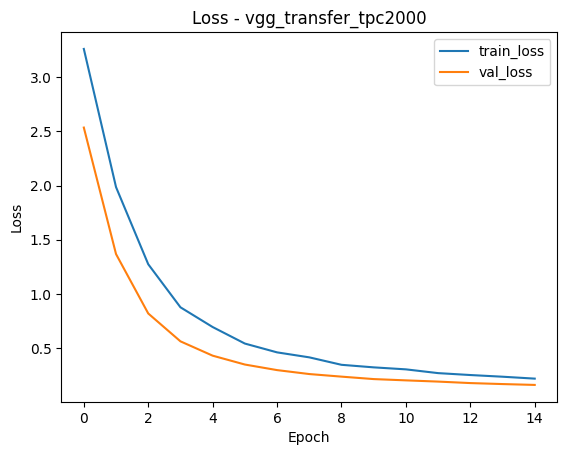

[Cats saved/skipped] train 4000/0, val 250/0, test 250/0
[Dogs saved/skipped] train 4000/0, val 250/0, test 250/0
[Final counts] train: Cat=4000, Dog=4000 | val: Cat=250, Dog=250 | test: Cat=250, Dog=250
Found 8000 files belonging to 2 classes.
Found 500 files belonging to 2 classes.
Found 500 files belonging to 2 classes.
Epoch 1/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 48s 139ms/step - accuracy: 0.6626 - loss: 1.3769 - val_accuracy: 0.8540 - val_loss: 0.5253 - learning_rate: 1.0000e-04
Epoch 2/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 34s 137ms/step - accuracy: 0.8165 - loss: 0.6332 - val_accuracy: 0.9180 - val_loss: 0.2582 - learning_rate: 1.0000e-04
Epoch 3/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - accuracy: 0.8819 - loss: 0.3783 - val_accuracy: 0.9440 - val_loss: 0.1716 - learning_rate: 1.0000e-04
Epoch 4/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 34s 136ms/step - accuracy: 0.8986 - loss: 0.3264 - val_accuracy: 0.9580 - val_loss: 0.1265 - learning_rate: 1.0000e-04
Epoch 5/15
250/250 ━━━━━━━━━━━━━━━━━━━━

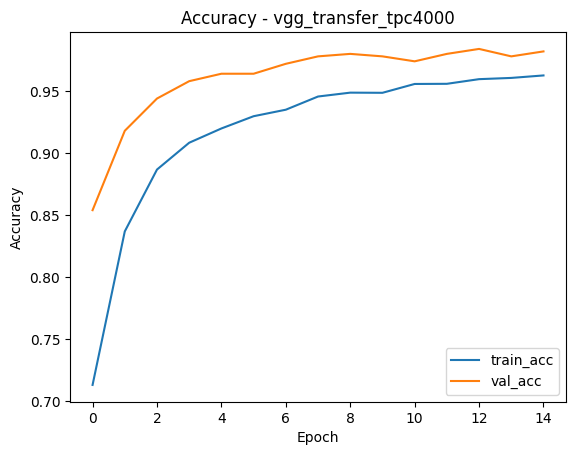

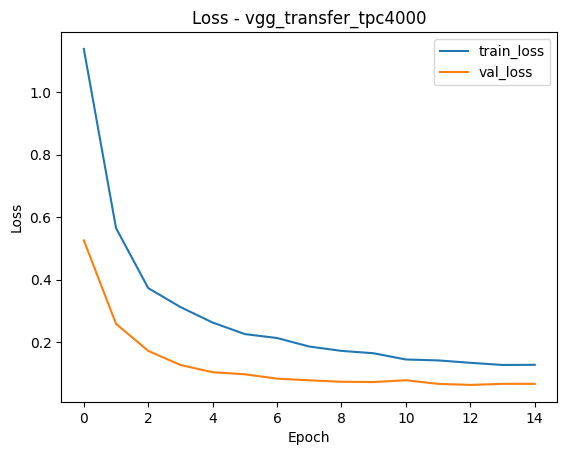

,run,phase,train_per_class,total_train,best_val_acc,test_acc
0,vgg_transfer_tpc500,transfer_only,500,1000,0.888,0.902
1,vgg_transfer_tpc2000,transfer_only,2000,4000,0.954,0.966
2,vgg_transfer_tpc4000,transfer_only,4000,8000,0.984,0.978


In [7]:
VAL_PER_CLASS = 250
TEST_PER_CLASS = 250
TRAIN_SIZES_PER_CLASS = [500, 2000, 4000]   # Step 1, Step 2, Step 3

RESULTS = []
ROOT = "/content/experiments_vgg"

for tpc in TRAIN_SIZES_PER_CLASS:
    exp_root = f"{ROOT}/train_per_class_{tpc}"
    build_balanced_split(exp_root, train_per_class=tpc,
                         val_per_class=VAL_PER_CLASS, test_per_class=TEST_PER_CLASS)
    train_ds, val_ds, test_ds = make_datasets(exp_root)

    # Transfer learning: freeze base, train top
    model_tl = make_vgg_transfer_model(train_base=False)
    summary_tl = train_and_evaluate(model_tl, train_ds, val_ds, test_ds,
                                    tag=f"vgg_transfer_tpc{tpc}", epochs=15)
    summary_tl["train_per_class"] = tpc
    summary_tl["total_train"] = tpc * 2
    summary_tl["phase"] = "transfer_only"
    RESULTS.append(summary_tl)

import pandas as pd
df_transfer = pd.DataFrame(RESULTS)
df_transfer = df_transfer[["run", "phase", "train_per_class", "total_train", "best_val_acc", "test_acc"]]
df_transfer.sort_values(["train_per_class", "phase"], inplace=True)
df_transfer.reset_index(drop=True, inplace=True)
df_transfer


Found 1000 files belonging to 2 classes.
Found 500 files belonging to 2 classes.
Found 500 files belonging to 2 classes.
Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 448ms/step - accuracy: 0.6228 - loss: 1.5642 - val_accuracy: 0.9060 - val_loss: 0.2415 - learning_rate: 1.0000e-05
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 313ms/step - accuracy: 0.9238 - loss: 0.2101 - val_accuracy: 0.9400 - val_loss: 0.1367 - learning_rate: 1.0000e-05
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 292ms/step - accuracy: 0.9627 - loss: 0.1170 - val_accuracy: 0.9700 - val_loss: 0.0933 - learning_rate: 1.0000e-05
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 443ms/step - accuracy: 0.9705 - loss: 0.0907 - val_accuracy: 0.9740 - val_loss: 0.0810 - learning_rate: 1.0000e-05
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9844 - loss: 0.0435 - val_accuracy: 0.9780 - val_loss: 0.0777 - learning_rate: 1.0000e-05
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 258ms/step - accuracy: 0.9824 - loss: 0.0400 - val_accura

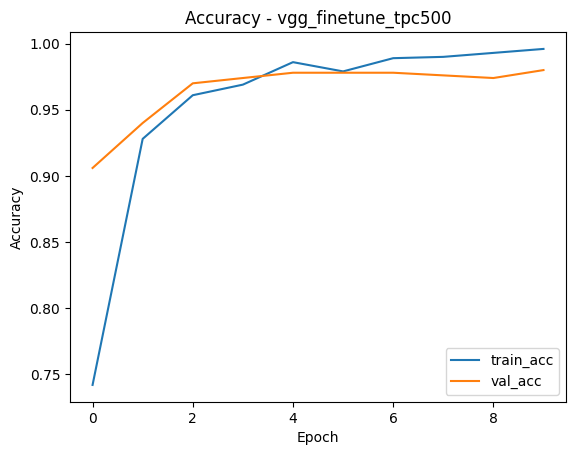

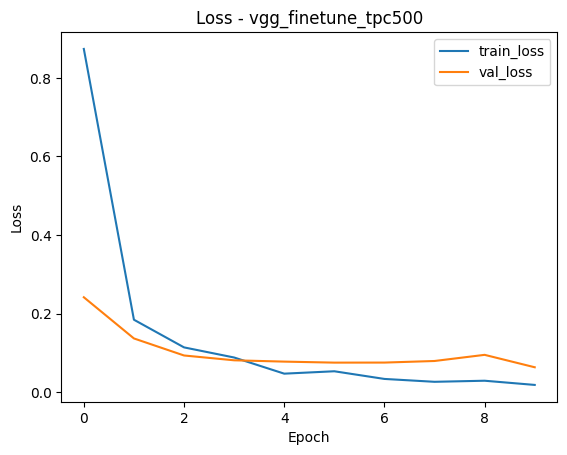

Found 4000 files belonging to 2 classes.
Found 500 files belonging to 2 classes.
Found 500 files belonging to 2 classes.
Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 57s 383ms/step - accuracy: 0.7168 - loss: 1.0560 - val_accuracy: 0.9480 - val_loss: 0.1331 - learning_rate: 1.0000e-05
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 51s 411ms/step - accuracy: 0.9639 - loss: 0.0935 - val_accuracy: 0.9600 - val_loss: 0.1107 - learning_rate: 1.0000e-05
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 51s 411ms/step - accuracy: 0.9759 - loss: 0.0656 - val_accuracy: 0.9620 - val_loss: 0.1029 - learning_rate: 1.0000e-05
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 45s 360ms/step - accuracy: 0.9854 - loss: 0.0417 - val_accuracy: 0.9700 - val_loss: 0.0969 - learning_rate: 1.0000e-05
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 51s 411ms/step - accuracy: 0.9878 - loss: 0.0373 - val_accuracy: 0.9720 - val_loss: 0.0904 - learning_rate: 1.0000e-05
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 43s 345ms/step - accuracy: 0.9865 - loss: 0.

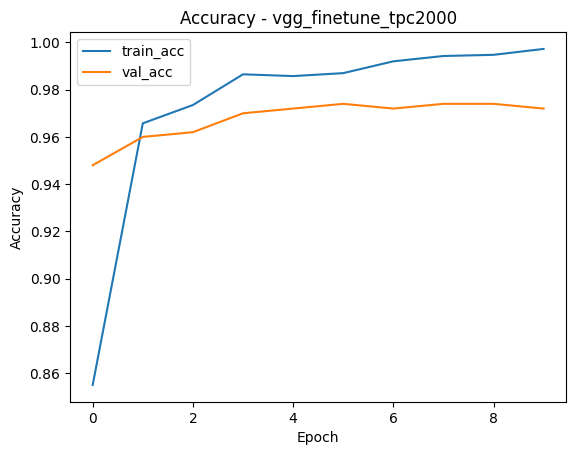

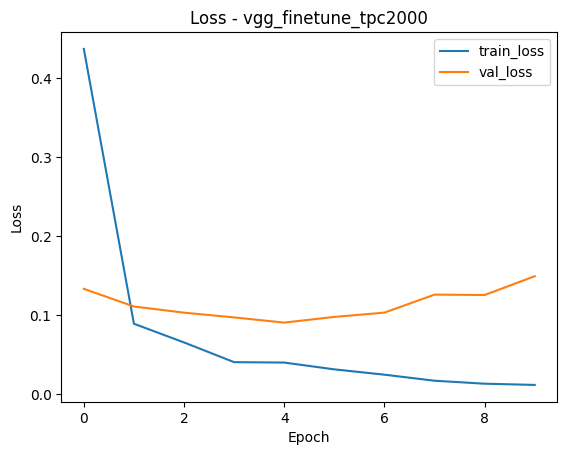

Found 8000 files belonging to 2 classes.
Found 500 files belonging to 2 classes.
Found 500 files belonging to 2 classes.
Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 97s 334ms/step - accuracy: 0.8765 - loss: 0.4282 - val_accuracy: 0.9780 - val_loss: 0.0572 - learning_rate: 1.0000e-05
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 78s 312ms/step - accuracy: 0.9792 - loss: 0.0615 - val_accuracy: 0.9800 - val_loss: 0.0534 - learning_rate: 1.0000e-05
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 53s 210ms/step - accuracy: 0.9818 - loss: 0.0509 - val_accuracy: 0.9720 - val_loss: 0.0693 - learning_rate: 1.0000e-05
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 75s 299ms/step - accuracy: 0.9892 - loss: 0.0322 - val_accuracy: 0.9840 - val_loss: 0.0419 - learning_rate: 1.0000e-05
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 53s 211ms/step - accuracy: 0.9890 - loss: 0.0294 - val_accuracy: 0.9800 - val_loss: 0.0470 - learning_rate: 1.0000e-05
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 70s 282ms/step - accuracy: 0.9949 - loss: 0.

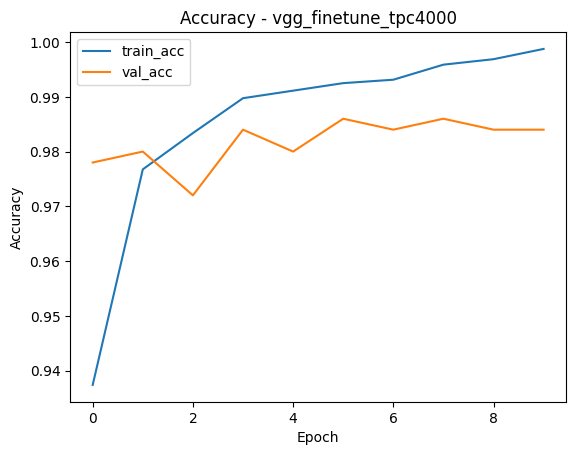

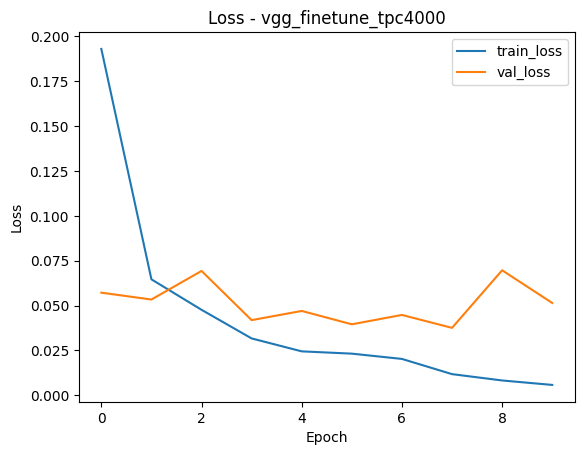

,run,phase,train_per_class,total_train,best_val_acc,test_acc
0,vgg_finetune_tpc500,fine_tune_from_block4,500,1000,0.980,0.972
1,vgg_transfer_tpc500,transfer_only,500,1000,0.888,0.902
2,vgg_finetune_tpc2000,fine_tune_from_block4,2000,4000,0.974,0.988
3,vgg_transfer_tpc2000,transfer_only,2000,4000,0.954,0.966
4,vgg_finetune_tpc4000,fine_tune_from_block4,4000,8000,0.986,0.992
5,vgg_transfer_tpc4000,transfer_only,4000,8000,0.984,0.978


In [8]:
# Fine-tune upper blocks for extra gains
# Unfreeze from "block4_conv1" (keeps early features stable)
for tpc in TRAIN_SIZES_PER_CLASS:
    exp_root = f"{ROOT}/train_per_class_{tpc}"
    train_ds, val_ds, test_ds = make_datasets(exp_root)

    model_ft = make_vgg_transfer_model(train_base=True, unfreeze_from="block4_conv1")
    summary_ft = train_and_evaluate(model_ft, train_ds, val_ds, test_ds,
                                    tag=f"vgg_finetune_tpc{tpc}", epochs=10)
    summary_ft["train_per_class"] = tpc
    summary_ft["total_train"] = tpc * 2
    summary_ft["phase"] = "fine_tune_from_block4"
    RESULTS.append(summary_ft)

df_all = pd.DataFrame(RESULTS)
df_all = df_all[["run", "phase", "train_per_class", "total_train", "best_val_acc", "test_acc"]]
df_all.sort_values(["train_per_class", "phase", "run"], inplace=True)
df_all.reset_index(drop=True, inplace=True)
df_all


In [9]:
csv_path = "/content/dogs_vs_cats_pretrained_results.csv"
df_all.to_csv(csv_path, index=False)
print("Saved:", csv_path)

print("\nTransfer-only summary:")
display(df_transfer)
print("\nAll runs (including fine-tune):")
display(df_all)


Saved: /content/dogs_vs_cats_pretrained_results.csv

Transfer-only summary:


,run,phase,train_per_class,total_train,best_val_acc,test_acc
0,vgg_transfer_tpc500,transfer_only,500,1000,0.888,0.902
1,vgg_transfer_tpc2000,transfer_only,2000,4000,0.954,0.966
2,vgg_transfer_tpc4000,transfer_only,4000,8000,0.984,0.978



All runs (including fine-tune):


,run,phase,train_per_class,total_train,best_val_acc,test_acc
0,vgg_finetune_tpc500,fine_tune_from_block4,500,1000,0.980,0.972
1,vgg_transfer_tpc500,transfer_only,500,1000,0.888,0.902
2,vgg_finetune_tpc2000,fine_tune_from_block4,2000,4000,0.974,0.988
3,vgg_transfer_tpc2000,transfer_only,2000,4000,0.954,0.966
4,vgg_finetune_tpc4000,fine_tune_from_block4,4000,8000,0.986,0.992
5,vgg_transfer_tpc4000,transfer_only,4000,8000,0.984,0.978


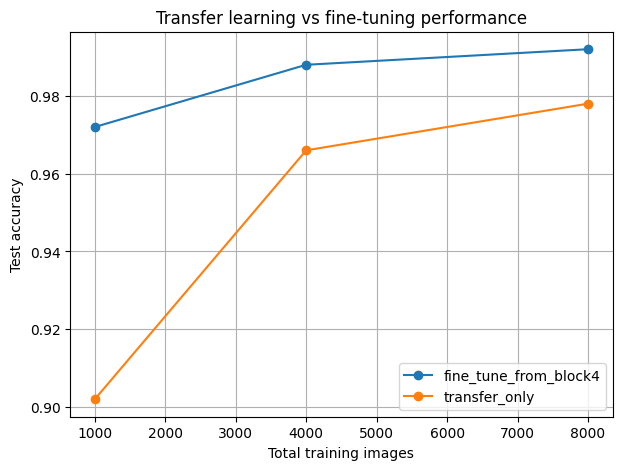

In [10]:
# optional for comparison

import matplotlib.pyplot as plt
import pandas as pd

df_all = pd.read_csv("/content/dogs_vs_cats_pretrained_results.csv")

plt.figure(figsize=(7,5))
for phase in df_all["phase"].unique():
    d = df_all[df_all["phase"] == phase]
    plt.plot(d["total_train"], d["test_acc"], marker="o", label=phase)
plt.xlabel("Total training images")
plt.ylabel("Test accuracy")
plt.title("Transfer learning vs fine-tuning performance")
plt.legend()
plt.grid(True)
plt.show()
